# The MNIST Dataset

#  Aims of this practical session

* To define and use different deep models using the Keras Models API, which is more general than the Sequential API we have used so far

* To examine the effect of batch normalisation and skip-forward connections on learning with deep networks. 

* To examine the effect of different amounts of regularisation on the same architecture, and to plot a graph of training and validation error as a function of the amount of regularisation

* To explore the MNIST dataset and plot learning curves to estimate error rates as a function of training set size

* To do your own exploration of applying different architectures to the MNIST data (and possibly also to the CIFAR data during the week)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import torch
import torch.nn as nn

In [3]:
import torch.nn.functional as F  # this includes tensor functions that we can use in backwards pass

In [4]:
import torchvision

In [5]:
import torchvision.datasets as datasets

In [6]:
from torchvision import transforms

# Pytorch datasets

Several well known datasets are provided with pytorch, and can be imported and easily used.

The MNIST dataset is a famous and has been used as a testbed of machine learning algorithms for more than 25 years. 

There is an interesting dataset called fashion_MNIST which is a plug-in replacement for the MNIST dataset, but which may have very different properties (it is grey-scale images). (It is possible that you may need to download this from the web if you want to use it. ) 

In [7]:
transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )

The next cell below downloads the MNIST dataset, and extracts it into the training set and the test set. The transforms above are used to alter the format to float32 and normalise the input values to small numbers

Downloading may take a while. 

In [8]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_list)

0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


C:\Users\cjchw\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


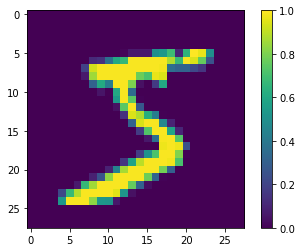

In [10]:
plt.imshow( mnist_trainset[0][0].view(28,28).numpy() )
plt.colorbar()

In [11]:
mnist_trainset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

We have normalised the values in the image to lie between 0 and 1.  However, I am baffled! According to the Pytorch documentation, the Normalize transform with the arguments I have given to it should normalise each image to have pixel values with a mean of 0 and a standard deviation of 1.  I am baffled....can anyone resolve this?  

I do not know whether a normalisation between 0 and 1, or a normalisation with mean 0 and std 1 would be better. One might try both. It is possible that the normalisation between 0 and 1 is superior because 0 has the meaning "blank space" and 1 has the meaning "dark ink" for every image. 

The exact form of normalisation may not be important, but it is important to do some normalisation to make the inputs of a defined size and -- most importantly -- that the inputs should be of roughly similar typical sizes. 

The reason for ensuring that inputs are of similar typical magnitudes is that the gradient of an input weight is proportional to the input: if we increase the typical values of one input by a factor of 10, the weight must be reduced by a factor of 10, but its gradients will increase by a factor of 10... This makes optimisation more difficult.  

Let us use a smaller set of data to train with at first, so that you can do more experiments more quickly. Let's take the first 4000 training examples only: 

In [12]:
mnist_trainset_small =  [ mnist_trainset[i] for i in range(0,4000) ] 

In [13]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_list)

In [14]:
type( mnist_trainset ) # unfortunately this type information is not very informative!

torchvision.datasets.mnist.MNIST

In [15]:
len( mnist_trainset )

60000

Ah! so this training set consists of a list of 60,000 pairs, each of which is an image and a digit

The first thing to do with any data is to look at it. 

In [16]:
im0 = mnist_trainset[0][0]

im0.shape

torch.Size([1, 28, 28])

To display this as a heatmap in numpy we need to reshape from (1,28,28) to (28,28), and convert to a numpy array: 

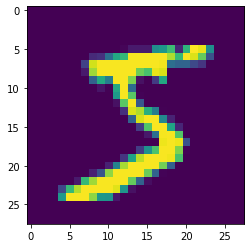

In [17]:
plt.imshow( im0.reshape(28,28).numpy()) # to pass it to matplotlib, we need to convert it to a 2 dimensional numpy array

Let's look at more of the digits. 

In [18]:
# This function will plot a grid of images with their titles

def plot_images(images_to_plot, titles=None, ncols=6, thefigsize=(18,18)):
    
    n_images = images_to_plot.shape[0]
    
    nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten() # we can number the axes from 0 upwards with a single integer

    for i in range(n_images):
        ax[i].imshow( images_to_plot[i,0,:,:].reshape(28,28), cmap=cm.Greys ) 
            # cmap=cm.Greys plots in Grey scale so the image looks as if it were written
        ax[i].axis('off')  
        if titles is not None:
            ax[i].set_title(titles[i])

In [ ]:
images_to_plot = np.array( [ mnist_trainset_small[i][0].numpy() for i in range(0,36)])
titles = [ mnist_trainset_small[i][1] for i in range(0,36) ] 
plot_images( images_to_plot, titles)

Classifying these isn't easy: look how different the 4s are from each other, and the 5s. 

Take a moment to look at the images carefully: what do you think are the difficulties of classifying these with a neural net?  How large are the features that you would need to use? 

# Neural network models for MNIST classification

It is best not to use the entire MNIST dataset as a training set because you will be training for the whole of the practical class. You will learn much more by training repeatedly on smaller subsets, and examining the effect of using different models and parameters. 

The easiest way to construct a (simple) neural network is to use the high-level constructor nn.Sequential, which simply chains a number of layers together. (This constructor hides some details - but not many details, and we will look at those later.) 

This constructs tensors containing initialised weights, and it wraps them in an object that can compute the forward (and backward) pass. 

In [19]:
model1 = nn.Sequential( 
        nn.Conv2d(1,6,3), # takes one input channel (greyscale), gives 6 output channes, each from a 3x3 convolutional neuron
        nn.ReLU()) 
      #  nn.Conv2d(6,6,3), # takes 26 x 26 to 24 x 24
       # nn.ReLU(), 
      #  nn.MaxPool2d(2,2) )
    

In [20]:
type( model1 )

torch.nn.modules.container.Sequential

In [21]:
mnist_trainset[0][0].shape

torch.Size([1, 28, 28])

In [22]:
output = model1( mnist_trainset[0][0].view(1,1,28,28) )

output.shape

torch.Size([1, 6, 26, 26])

In [25]:
model1 = [] # reclaim the space

Generally it is better practice to construct a NN by subclassing the pytorch class nn.Module, so that we have all the code necessary for initialising the neural net and doing the forward pass in one place.  

(A very common and easy mistake in working with a NN is to forget to re-initialise it, and then train it repeatedly under different conditions without resetting the weights to random initialised values: this produces bad experimental results, which may take a while to identify...therefore it is MUCH SAFER to automatically provide yourself with a class for your NN so that you can automatically initialise new instances of it...) 

In [26]:
# our simplest neural net - it is just going to be a linear layer and then softmax
class NN1( nn.Module ):
    
    def __init__(self): 
        super(NN1, self).__init__()
        self.layers = nn.Sequential( 
            nn.Flatten(), 
            nn.Linear(784,10))  # a linear layer (a matrix, plus biases) with 784 inputs and 10 outputs
             # if we are going to make probabilistic categorical predictions, it is more flexible to allow unnormalised 
             # outputs, because we can use  different functions for the predictions and and in calculating the loss, as 
             # we shall soon see
    
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [27]:
nn1 = NN1()

In [44]:
tmp = nn1.forward( mnist_trainset[0][0])
tmp

tensor([[-0.0796, -0.1956,  0.0471, -0.0576, -0.1083,  0.3235,  0.0865, -0.1110,
         -0.0092, -0.1041]], grad_fn=<AddmmBackward>)

This output consists of unbounded positive and negative values - it needs to be converted to probabilities to make a probabilistic predictions of each of the 10 classes. 

The standard and most commonly used method of mapping arbitrary numeric values to probabilities is softmax 

Let's see the predictions using softmax: 


In [45]:
tmp_probs = F.softmax( tmp, dim=1)
tmp_probs 

tensor([[0.0933, 0.0831, 0.1059, 0.0954, 0.0907, 0.1397, 0.1102, 0.0904, 0.1001,
         0.0911]], grad_fn=<SoftmaxBackward>)

As we might hope, these predictions are random values of approximately 0.1 : this is what we should expect, because the network has been initialised with random weights, and it has not yet learned to make good predictions. 

Now, the true class of the 0th item in the trainset is 5. 

Let us find the log-loss for this prediction: 

In [46]:
# to examine the values of tensors with gradients attached, we must first detach the gradient, and then 
# convert to numpy, thus: 
tmp_probs_n = tmp_probs.detach().numpy()
tmp_probs_n

array([[0.09333082, 0.08310757, 0.10593501, 0.0954067 , 0.09069076,
        0.13966897, 0.11019802, 0.09044626, 0.10014161, 0.09107427]],
      dtype=float32)

In [47]:
tmp_probs_n[0,5]

0.13966897

In [48]:
-np.log( tmp_probs_n[0,5] ) 

1.9684801

At last: this is the log-loss, which is the negative log of the predicted probability of the true class (in this case 5) 

A typical predicted probability will be near to 0.1, with a loss that is near to -np.log(0.1) which is -2.30

Our next task is to construct the loss function, which will produce a single loss for a batch of examples. This is the final leaf of the computational graph, from which we back-propagate to find the gradients. 

There is a single torch function that will take unnormalised outputs, and combine softmax and log-loss efficiently: 

In [41]:
loss_function = nn.CrossEntropyLoss() 
# I am unsure why the loss function has to be created like this; the documentation does not enlighten me

In [53]:
loss_function( tmp, torch.LongTensor([5]))

tensor(1.9685, grad_fn=<NllLossBackward>)

Excellent - this loss should be the same as the one we computed directly 

We now need to check that we can compute the losses correctly for a batch of training examples

In [63]:
# DataLoader is a useful utility class provided by pytorch for extracting minibatches from 
# a large dataset. 

trainloader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader( mnist_testset, batch_size=4, shuffle=True)

# if you want to change the batch size, you need to define a new dataloader: 
# the dataloader is a lightweight class that just provides iteration over the dataset

In [64]:
# we construct a (temporary) iterator from trainloader, and we get the first minibatch
tmpiter = iter(trainloader)

images, labels = tmpiter.next() # the minibatch is a list of [ images, labels ]

# let's check what form the images and labels come in

In [65]:
images.shape # the first index is the data item, then it is 1x28x28 images

torch.Size([4, 1, 28, 28])

In [66]:
labels

tensor([1, 5, 7, 3])

In [60]:
tmp = nn1.forward( images )
tmp  # note that these are 4 sets of probabilistic predictions, but unnormalised by softmax. 

tensor([[ 0.0103, -0.1198, -0.2532, -0.1224,  0.0168,  0.2111, -0.0562, -0.1871,
          0.0138,  0.0679],
        [ 0.3531,  0.0146, -0.1720, -0.0741, -0.1710,  0.2341,  0.0029, -0.1459,
         -0.1867, -0.3274],
        [-0.2412,  0.3560, -0.1234, -0.3206, -0.2233,  0.4257, -0.1279, -0.2392,
         -0.0168, -0.5086],
        [-0.2341, -0.0715, -0.2659, -0.0658, -0.3172,  0.3274, -0.1531, -0.2684,
          0.1624, -0.1116]], grad_fn=<AddmmBackward>)

In [67]:
# Finally we compute the loss: the loss function computes all the individual losses, and averages them
loss_function(tmp, labels )

tensor(2.2998, grad_fn=<NllLossBackward>)

By calling the .backward() method on the output of the loss_function, we can back-propagate and compute the gradients of the loss wrt all the weights. 

To optimise the weights, it is convenient to use another class, that takes the neural net parameters, and updates them using the gradients. Many optimisation methods - such as RMSProp and ADAM - require additional data structures (moving averages of gradients and squared gradients). 

The .parameters() method gives the parameters of the network. 

In [68]:
nn1.parameters()

<generator object Module.parameters at 0x000001DE444D60B0>

In [74]:
params = [ p for p in nn1.parameters() ] 

In [75]:
params

[Parameter containing:
 tensor([[-0.0239, -0.0033,  0.0074,  ...,  0.0049,  0.0271,  0.0294],
         [ 0.0099,  0.0341,  0.0344,  ..., -0.0344, -0.0177,  0.0239],
         [-0.0348,  0.0242, -0.0015,  ...,  0.0213, -0.0100,  0.0115],
         ...,
         [-0.0186, -0.0079, -0.0065,  ...,  0.0109,  0.0221,  0.0038],
         [-0.0075, -0.0145, -0.0085,  ..., -0.0243, -0.0247,  0.0238],
         [-0.0065,  0.0272,  0.0250,  ...,  0.0296,  0.0097, -0.0244]],
        requires_grad=True),
 Parameter containing:
 tensor([-1.1895e-02,  2.7314e-02,  2.2021e-02, -1.2930e-05,  2.8325e-02,
         -2.5938e-02, -3.1787e-02,  3.3480e-02, -2.5981e-02, -5.7703e-03],
        requires_grad=True)]

In [78]:
[ p.shape for p in params ]

[torch.Size([10, 784]), torch.Size([10])]

In [79]:
import torch.optim as optim 

optimizer1 = optim.RMSprop(nn1.parameters(), lr=0.01)

Now we are ready to construct a learning loop.

In [86]:
# notice that we create all the ingredients of the process again within this cell, 
# so that we train a newly initialised neural net with a newly initialised optimizer
# containing the parameters of that neural net ....


trainloader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader( mnist_testset, batch_size=32, shuffle=True)

nn1 = NN1()
optimizer1 = optim.RMSprop( nn1.parameters(), lr=0.0001 )

for epoch in range(200): # number of times to loop over the dataset
    current_loss = 0.0 
    n_mini_batches = 0
    
    for i, mini_batch in enumerate( trainloader, 0 ):
        images, labels = mini_batch
        
        # zero the parameter gradients
        # all the parameters that are being updated are in the optimizer, 
        # so if we zero the gradients of all the tensors in the optimizer, 
        # that is the safest way to zero all the gradients
        optimizer1.zero_grad()
        
        outputs = nn1(images)
        loss = loss_function ( outputs, labels )
        loss.backward() # does the backward pass and computes all gradients
        optimizer1.step() # does one optimisation step
        
        n_mini_batches += 1 
        current_loss += loss.item() # remember that the loss is a zero-order tensor
        # so that to extract its value, we use .item(), as we cannot index as there are no dimensions
        
     
    print('Epoch %d loss: %.3f' %(epoch+1, current_loss / n_mini_batches ))
            


Epoch 1 loss: 1.922
Epoch 2 loss: 1.570
Epoch 3 loss: 1.352
Epoch 4 loss: 1.187
Epoch 5 loss: 1.056
Epoch 6 loss: 0.952
Epoch 7 loss: 0.867
Epoch 8 loss: 0.799
Epoch 9 loss: 0.742
Epoch 10 loss: 0.695
Epoch 11 loss: 0.655
Epoch 12 loss: 0.621
Epoch 13 loss: 0.592
Epoch 14 loss: 0.566
Epoch 15 loss: 0.544
Epoch 16 loss: 0.524
Epoch 17 loss: 0.507
Epoch 18 loss: 0.491
Epoch 19 loss: 0.476
Epoch 20 loss: 0.463
Epoch 21 loss: 0.452
Epoch 22 loss: 0.441
Epoch 23 loss: 0.431
Epoch 24 loss: 0.422
Epoch 25 loss: 0.413
Epoch 26 loss: 0.406
Epoch 27 loss: 0.398
Epoch 28 loss: 0.392
Epoch 29 loss: 0.385
Epoch 30 loss: 0.379
Epoch 31 loss: 0.373
Epoch 32 loss: 0.368
Epoch 33 loss: 0.363
Epoch 34 loss: 0.358
Epoch 35 loss: 0.354
Epoch 36 loss: 0.349
Epoch 37 loss: 0.345
Epoch 38 loss: 0.341
Epoch 39 loss: 0.337
Epoch 40 loss: 0.334
Epoch 41 loss: 0.330
Epoch 42 loss: 0.327
Epoch 43 loss: 0.324
Epoch 44 loss: 0.321
Epoch 45 loss: 0.317
Epoch 46 loss: 0.315
Epoch 47 loss: 0.312
Epoch 48 loss: 0.309
E

## Calculating Validation accuracy and loss

It's a good idea to turn off gradient computations when 

In [109]:
# this code calculates the error rate on the validation set
correct = 0 
total = 0 
with torch.no_grad():  # we do not neet to compute the gradients when making predictions on the validation set
    for data in testloader: 
        images, labels = data
        outputs = nn1(images)
        _, predicted = torch.max( outputs, dim=1)
        total += labels.size(0) # the number of labels, which is just the size of the batch 
        correct += (predicted == labels).sum().item() # once again, note that the sum is a zero-dimensional tensor, 
                                                      # so we must access its value using .item()
print( "Accuracy on test set: %d %%" %(100 * correct/total))


Accuracy on test set: 90 %


## Things to do

1. modify the learning loop to print out the validation accuracy after each epoch

2. modify the learning loop to print both the validation accuracy and the loss after each epoch

3. create multi-layer networks using any architecture that you want...and investigate their behaviour on this dataset
   (You may find it faster and more interesting to train with the small training set)

## Examining model parameters

We can extract, examine, save and reload, and print the parameters of the model using the state_dict which
is a dictionary of convenient names mapping to the model's parameter tensors:  


Remember that we need to use .detach().numpy() to detach the value of a tensor from its gradients, and then create a numpy view of the values, before we can plot histograms of weights, etc and perform other analyses in numpy 

In [87]:
print( "Model's state dict:")
for param_tensor in nn1.state_dict():
    print( param_tensor, "\t", nn1.state_dict()[param_tensor].size())


Model's state dict:
layers.1.weight 	 torch.Size([10, 784])
layers.1.bias 	 torch.Size([10])



We can do the same for the optimizer. 

Note that an RMSprop optimizer has non-trivial state, and the first element of the state is (annoyingly) a dict that contains a tensor.

In [94]:
print( "Optimizer's state dict: ")
for var_name in optimizer1.state_dict(): 
    print( var_name, "\t", optimizer1.state_dict()[var_name])

Optimizer's state dict: 
state 	 {0: {'step': 25000, 'square_avg': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}, 1: {'step': 25000, 'square_avg': tensor([4.7917e-05, 1.4140e-04, 2.5350e-04, 2.7831e-04, 2.1680e-04, 3.3515e-04,
        9.6171e-05, 2.5513e-04, 3.2924e-04, 3.4000e-04])}}
param_groups 	 [{'lr': 0.0001, 'momentum': 0, 'alpha': 0.99, 'eps': 1e-08, 'centered': False, 'weight_decay': 0, 'params': [0, 1]}]


## Saving and reloading models

We will often want to save a net that we have trained, and reload it. Pytorch provides convenient methods of doing this:

In [ ]:
# specify a path
PATH = "saved_state_dict.pt" # pt suffice for checkpoint

# Save the model
torch.save( nn1.state_dict(), PATH)

# Reload the model into a new neural network object
nn1_reloaded = NN1()
nn1_reloaded.load_state_dict( torch.load( PATH ))


nn1_reloaded.eval() # sets dropout and batch normalisation layers to evaluation mode before inference 


In [ ]:
# we may also save and load entire models

PATH = "entire_model.pt"

#Save 
torch.save( nn1, PATH )

#Load
nn1_reloaded_whole = torch.load( PATH )